In [2]:
!pip install tensorflow keras 

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import tensorflow as tf
import random

# Set random seed for NumPy
np.random.seed(42)

# Set random seed for TensorFlow
tf.random.set_seed(42)

# Set random seed for Python's random module
random.seed(42)


Only run the next cell if the data has not been split into training and validation

In [4]:
import os
import shutil
import random

# Set random seed
random.seed(42)

# Define paths
data_dir = 'data/'
train_dir = 'train/'
test_dir = 'test/'

# Clear train and test directories
shutil.rmtree(train_dir, ignore_errors=True)
shutil.rmtree(test_dir, ignore_errors=True)
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Get list of image filenames in each class folder
malignant_images = os.listdir(os.path.join(data_dir, 'malignant'))
normal_images = os.listdir(os.path.join(data_dir, 'normal'))

# Shuffle the filenames
random.shuffle(malignant_images)
random.shuffle(normal_images)

# Define the number of images for training and testing
train_count = 200
test_count = 50

# Split images into training and testing sets
malignant_train_images = malignant_images[:train_count]
malignant_test_images = malignant_images[train_count:train_count+test_count]

normal_train_images = normal_images[:train_count]
normal_test_images = normal_images[train_count:train_count+test_count]

# Copy images to train and test folders
for img in malignant_train_images:
    src = os.path.join(data_dir, 'malignant', img)
    dst_train = os.path.join(train_dir, 'malignant', img)
    os.makedirs(os.path.dirname(dst_train), exist_ok=True)  # Create destination directory if it doesn't exist
    shutil.copyfile(src, dst_train)

for img in malignant_test_images:
    src = os.path.join(data_dir, 'malignant', img)
    dst_test = os.path.join(test_dir, 'malignant', img)
    os.makedirs(os.path.dirname(dst_test), exist_ok=True)  # Create destination directory if it doesn't exist
    shutil.copyfile(src, dst_test)

for img in normal_train_images:
    src = os.path.join(data_dir, 'normal', img)
    dst_train = os.path.join(train_dir, 'normal', img)
    os.makedirs(os.path.dirname(dst_train), exist_ok=True)  # Create destination directory if it doesn't exist
    shutil.copyfile(src, dst_train)

for img in normal_test_images:
    src = os.path.join(data_dir, 'normal', img)
    dst_test = os.path.join(test_dir, 'normal', img)
    os.makedirs(os.path.dirname(dst_test), exist_ok=True)  # Create destination directory if it doesn't exist
    shutil.copyfile(src, dst_test)

print("Data copied successfully.")


Data copied successfully.


Setting up target size 

In [5]:
import os

# Define directories
train_dir = 'train/'
test_dir = 'test/'

# Count number of files in train directory
train_malignant_count = len(os.listdir(os.path.join(train_dir, 'malignant')))
train_normal_count = len(os.listdir(os.path.join(train_dir, 'normal')))

# Count number of files in test directory
test_malignant_count = len(os.listdir(os.path.join(test_dir, 'malignant')))
test_normal_count = len(os.listdir(os.path.join(test_dir, 'normal')))

# Print counts
print("Train directory:")
print(f"Malignant: {train_malignant_count} images")
print(f"Normal: {train_normal_count} images")

print("\nTest directory:")
print(f"Malignant: {test_malignant_count} images")
print(f"Normal: {test_normal_count} images")


Train directory:
Malignant: 200 images
Normal: 200 images

Test directory:
Malignant: 50 images
Normal: 50 images


In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# Define image dimensions and other parameters
img_height = 128
img_width = 128
batch_size = 32
epochs = 10

# Create ImageDataGenerators for train and test data
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255, seed=42)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')






Found 400 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [7]:
import tensorflow as tf
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score

class CustomKerasClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, build_fn, optimizer='adam', epochs=10, batch_size=32, verbose=1):
        self.build_fn = build_fn
        self.optimizer = optimizer
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose

    def fit(self, X, y):
        self.model = self.build_fn()
        self.model.compile(optimizer=self.optimizer,
                           loss='binary_crossentropy',
                           metrics=['accuracy'])
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=self.verbose)
        return self

    def predict(self, X):
        return (self.model.predict(X) > 0.5).astype('int32')

    def score(self, X, y):
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)


In [8]:

from sklearn.model_selection import GridSearchCV

# Define CNN model
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
    return model

# Wrap Keras model in a scikit-learn compatible classifier
model = CustomKerasClassifier(build_fn=create_model, verbose=0)




In [21]:

# Define hyperparameters for grid search
param_grid = {
    'batch_size': [32, 64],
    'epochs': [10, 20],
    'optimizer': ['adam', 'sgd']
}

# Load the images
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)

# Grid search
grid_search = GridSearchCV(estimator=CustomKerasClassifier(create_model), param_grid=param_grid, cv=5, return_train_score=True)
grid_search.fit(train_images, train_labels)

# Get the best model
best_model = grid_search.best_estimator_

# Evaluate the best model
test_accuracy = best_model.score(test_images, test_labels)
print("Test Accuracy:", test_accuracy)


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.5600 - loss: 0.6880
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.5600 - loss: 0.8572
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.6000 - loss: 0.4995
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.8000 - loss: 0.5164
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.6800 - loss: 0.4855
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.7200 - loss: 0.4514
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.5600 - loss: 0.4695
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.9200 - loss: 0.4070
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.8000 - loss: 0.4081
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.8000 - loss: 0.4054
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
Epoch 1/10


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.5600 - loss: 0.6734
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.5600 - loss: 0.9866
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.8400 - loss: 0.4796
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.6400 - loss: 0.5379
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.6400 - loss: 0.4863
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.5600 - loss: 0.4942
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.7200 - loss: 0.4233
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.8000 - loss: 0.4106
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.8000 - loss: 0.3948
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.9200 - loss: 0.3625
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
Epoch 1/10


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.3846 - loss: 0.6972
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.5385 - loss: 0.6122
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.8846 - loss: 0.4555
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.7692 - loss: 0.4010
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.7692 - loss: 0.3401
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.9231 - loss: 0.3012
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.9231 - loss: 0.2604
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.9615 - loss: 0.2286
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.9231 - loss: 0.2829
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.9615 - loss: 0.1524
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
Epoch 1/10


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5769 - loss: 0.6813
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.5769 - loss: 0.4850
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.8077 - loss: 0.6110
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.8846 - loss: 0.3464
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.8077 - loss: 0.3544
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.8846 - loss: 0.3239
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.8846 - loss: 0.2828
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.8846 - loss: 0.2560
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.8846 - loss: 0.2424
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.8846 - loss: 0.2116
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
Epoch 1/10


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.2692 - loss: 0.6946
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.5769 - loss: 0.5472
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.8462 - loss: 0.4227
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.7308 - loss: 0.3689
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.7692 - loss: 0.3091
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.9615 - loss: 0.2669
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.9615 - loss: 0.2209
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.9615 - loss: 0.1737
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 1.0000 - loss: 0.1364
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 1.0000 - loss: 0.1045
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
Epoch 1/10


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 999ms/step - accuracy: 0.3200 - loss: 0.7040
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.6800 - loss: 0.6786
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.6000 - loss: 0.6591
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.5600 - loss: 0.6437
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.5600 - loss: 0.6311
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.5600 - loss: 0.6194
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.5600 - loss: 0.6087
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.6800 - loss: 0.5988
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.6800 - loss: 0.5892
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.6800 - loss: 0.5798
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
Epoch 1/10


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4800 - loss: 0.6874
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.5200 - loss: 0.6767
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.5600 - loss: 0.6673
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.5600 - loss: 0.6593
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.5600 - loss: 0.6524
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.5600 - loss: 0.6460
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.5600 - loss: 0.6400
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.5600 - loss: 0.6342
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.5600 - loss: 0.6286
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.5600 - loss: 0.6230
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
Epoch 1/10


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3077 - loss: 0.6960
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.5000 - loss: 0.6868
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.5385 - loss: 0.6789
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.5385 - loss: 0.6723
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.5385 - loss: 0.6661
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.5385 - loss: 0.6603
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.5385 - loss: 0.6546
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.5385 - loss: 0.6489
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.5385 - loss: 0.6430
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.5385 - loss: 0.6369
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
Epoch 1/10


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4615 - loss: 0.6879
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.5769 - loss: 0.6668
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.5769 - loss: 0.6486
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.5769 - loss: 0.6327
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.5769 - loss: 0.6180
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.5769 - loss: 0.6043
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.5769 - loss: 0.5916
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.5769 - loss: 0.5794
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.5769 - loss: 0.5676
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.5769 - loss: 0.5562
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
Epoch 1/10


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5385 - loss: 0.6830
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.5769 - loss: 0.6677
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.5769 - loss: 0.6544
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.5769 - loss: 0.6426
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.5769 - loss: 0.6314
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.5769 - loss: 0.6205
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.5769 - loss: 0.6098
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.5769 - loss: 0.5992
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.5769 - loss: 0.5889
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.5769 - loss: 0.5788
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
Epoch 1/20


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.4800 - loss: 0.6862
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.5600 - loss: 0.6985
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.8000 - loss: 0.5051
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.6800 - loss: 0.4945
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.7200 - loss: 0.4466
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.7200 - loss: 0.4252
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.8800 - loss: 0.3867
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.8400 - loss: 0.3618
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.9600 - loss: 0.3237
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.9200 - loss: 0.2951
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.9600 - loss: 0.2599
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.9600 - loss: 0.2176
Epo

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.2800 - loss: 0.7030
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.5600 - loss: 0.6478
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.6000 - loss: 0.5207
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.7200 - loss: 0.4952
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.7600 - loss: 0.4427
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.8800 - loss: 0.4140
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.8800 - loss: 0.3720
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.9200 - loss: 0.3393
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.8800 - loss: 0.2992
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.9200 - loss: 0.2588
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.9600 - loss: 0.2329
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.9600 - loss: 0.1912
Epo

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.5000 - loss: 0.6884
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.5385 - loss: 0.6210
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.8846 - loss: 0.4186
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.8846 - loss: 0.3996
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.7692 - loss: 0.3439
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.7692 - loss: 0.3146
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.9231 - loss: 0.2737
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.9231 - loss: 0.2287
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.9615 - loss: 0.1913
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.9231 - loss: 0.1893
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.9615 - loss: 0.1540
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 1.0000 - loss: 0.0962
Epo

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.5769 - loss: 0.6589
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.5769 - loss: 0.7546
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.8846 - loss: 0.3915
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.7692 - loss: 0.4231
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.7692 - loss: 0.3770
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.7692 - loss: 0.3323
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.7692 - loss: 0.3185
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.8846 - loss: 0.2997
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.8846 - loss: 0.2750
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.8846 - loss: 0.2560
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.9615 - loss: 0.2286
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.9231 - loss: 0.2055
Epo

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.6154 - loss: 0.6754
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.5769 - loss: 0.7405
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.8462 - loss: 0.4284
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.7308 - loss: 0.4483
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.7308 - loss: 0.3860
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.8462 - loss: 0.3430
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.7692 - loss: 0.3333
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.8462 - loss: 0.2950
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.8462 - loss: 0.3001
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.9615 - loss: 0.2273
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.9231 - loss: 0.2494
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.9615 - loss: 0.1795
Epo

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5200 - loss: 0.6890
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.5600 - loss: 0.6816
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.5600 - loss: 0.6745
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.5600 - loss: 0.6679
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.5600 - loss: 0.6618
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.5600 - loss: 0.6561
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.5600 - loss: 0.6508
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.5600 - loss: 0.6458
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.5600 - loss: 0.6411
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.5600 - loss: 0.6364
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.5600 - loss: 0.6317
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.5600 - loss: 0.6269
Epo

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 993ms/step - accuracy: 0.4400 - loss: 0.6927
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.5200 - loss: 0.6776
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.5600 - loss: 0.6651
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.5600 - loss: 0.6542
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.5600 - loss: 0.6450
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.5600 - loss: 0.6367
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.5600 - loss: 0.6287
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.5600 - loss: 0.6211
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.5600 - loss: 0.6136
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.5600 - loss: 0.6063
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.5600 - loss: 0.5991
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.5600 - loss: 0.5923


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3846 - loss: 0.7121
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.3846 - loss: 0.6995
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.5000 - loss: 0.6883
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.5385 - loss: 0.6784
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.5385 - loss: 0.6695
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.5769 - loss: 0.6612
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.5385 - loss: 0.6533
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.5385 - loss: 0.6461
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.5385 - loss: 0.6391
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.5385 - loss: 0.6321
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.5385 - loss: 0.6253
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.5385 - loss: 0.6183
Epo

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3077 - loss: 0.7382
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.3077 - loss: 0.7170
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.3462 - loss: 0.7007
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.3846 - loss: 0.6876
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.8077 - loss: 0.6765
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.8462 - loss: 0.6671
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.6923 - loss: 0.6580
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.6538 - loss: 0.6494
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.6154 - loss: 0.6413
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.5769 - loss: 0.6333
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.5769 - loss: 0.6252
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.5769 - loss: 0.6170
Epo

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5769 - loss: 0.6877
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.7308 - loss: 0.6824
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.8077 - loss: 0.6773
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.7692 - loss: 0.6724
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.7308 - loss: 0.6677
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.6538 - loss: 0.6631
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.6538 - loss: 0.6586
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.6538 - loss: 0.6539
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.6538 - loss: 0.6490
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.6154 - loss: 0.6441
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.6154 - loss: 0.6395
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.6154 - loss: 0.6348
Epo

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.5600 - loss: 0.6761
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.5600 - loss: 0.9157
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.7200 - loss: 0.4818
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.6800 - loss: 0.5172
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.6800 - loss: 0.4837
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.6800 - loss: 0.4390
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.6400 - loss: 0.4315
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.9200 - loss: 0.3934
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.8400 - loss: 0.3728
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.9200 - loss: 0.3466
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
Epoch 1/10


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.2800 - loss: 0.7088
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.5600 - loss: 0.6884
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.5600 - loss: 0.5461
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.6800 - loss: 0.5289
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.7600 - loss: 0.4772
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.6800 - loss: 0.4392
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 1.0000 - loss: 0.3995
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.8800 - loss: 0.3652
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.9200 - loss: 0.3298
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 1.0000 - loss: 0.2856
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
Epoch 1/10


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5000 - loss: 0.6925
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.5385 - loss: 0.7325
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.8846 - loss: 0.4354
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.7692 - loss: 0.4296
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.7692 - loss: 0.3692
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.7692 - loss: 0.3320
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.9231 - loss: 0.3070
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.8846 - loss: 0.3150
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.8846 - loss: 0.2605
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.9615 - loss: 0.2453
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
Epoch 1/10


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5769 - loss: 0.6806
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.5769 - loss: 0.5340
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.8846 - loss: 0.4073
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - accuracy: 0.8846 - loss: 0.3566
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.8846 - loss: 0.3214
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.8846 - loss: 0.2972
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.9615 - loss: 0.2723
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.8846 - loss: 0.2434
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.9615 - loss: 0.1964
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.9615 - loss: 0.1672
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
Epoch 1/10


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.5769 - loss: 0.6853
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.5769 - loss: 0.4728
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.8462 - loss: 0.4327
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.8462 - loss: 0.3215
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.9231 - loss: 0.3154
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.9615 - loss: 0.2381
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.9615 - loss: 0.2171
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.9615 - loss: 0.1628
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.9615 - loss: 0.1617
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 1.0000 - loss: 0.1098
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
Epoch 1/10


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4800 - loss: 0.6943
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.5600 - loss: 0.6805
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.5600 - loss: 0.6690
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.5600 - loss: 0.6585
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.5600 - loss: 0.6489
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.5600 - loss: 0.6397
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.5600 - loss: 0.6315
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.5600 - loss: 0.6237
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.5600 - loss: 0.6164
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.5600 - loss: 0.6092
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
Epoch 1/10


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 999ms/step - accuracy: 0.4400 - loss: 0.6892
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.5600 - loss: 0.6782
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.5600 - loss: 0.6687
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.5600 - loss: 0.6603
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.5600 - loss: 0.6527
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.5600 - loss: 0.6456
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.5600 - loss: 0.6392
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.5600 - loss: 0.6326
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.5600 - loss: 0.6260
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.5600 - loss: 0.6197
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
Epoch 1/10


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5385 - loss: 0.6717
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.6538 - loss: 0.6513
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.6538 - loss: 0.6339
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.6538 - loss: 0.6178
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.6538 - loss: 0.6025
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.6538 - loss: 0.5881
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.6538 - loss: 0.5740
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.6538 - loss: 0.5600
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.7308 - loss: 0.5463
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.8077 - loss: 0.5325
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
Epoch 1/10


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3077 - loss: 0.7071
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.4615 - loss: 0.6933
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.5385 - loss: 0.6815
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.6154 - loss: 0.6711
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.6154 - loss: 0.6617
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.6154 - loss: 0.6527
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.5769 - loss: 0.6443
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.5769 - loss: 0.6361
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.5769 - loss: 0.6280
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.5769 - loss: 0.6200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Epoch 1/10


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 969ms/step - accuracy: 0.5385 - loss: 0.6859
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.5769 - loss: 0.6609
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.5769 - loss: 0.6405
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.5769 - loss: 0.6233
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.5769 - loss: 0.6077
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.5769 - loss: 0.5928
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.5769 - loss: 0.5789
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.5769 - loss: 0.5651
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.5769 - loss: 0.5517
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.7308 - loss: 0.5386
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
Epoch 1/20


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.4800 - loss: 0.6944
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.5600 - loss: 0.8274
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.8000 - loss: 0.4798
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.8000 - loss: 0.5083
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.6800 - loss: 0.4642
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.7600 - loss: 0.4308
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.7200 - loss: 0.4257
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.8400 - loss: 0.3848
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.8000 - loss: 0.3714
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.8400 - loss: 0.3449
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.9200 - loss: 0.3042
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.9200 - loss: 0.2725
Epo

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.2800 - loss: 0.7139
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.5600 - loss: 0.7816
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - accuracy: 0.5600 - loss: 0.5180
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.6400 - loss: 0.5109
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.6800 - loss: 0.4701
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.7200 - loss: 0.4566
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.8000 - loss: 0.4151
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.8000 - loss: 0.3977
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.9200 - loss: 0.3602
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.9200 - loss: 0.3340
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.9600 - loss: 0.2884
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.9600 - loss: 0.2599
Epo

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.3077 - loss: 0.7126
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.5385 - loss: 0.6651
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.8846 - loss: 0.4831
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.7692 - loss: 0.4496
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.7692 - loss: 0.3831
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.7692 - loss: 0.3432
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.8846 - loss: 0.3129
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.8846 - loss: 0.2850
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.9231 - loss: 0.2458
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.9615 - loss: 0.2112
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.9231 - loss: 0.1857
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 1.0000 - loss: 0.1332
Epo

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.4231 - loss: 0.6968
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.5769 - loss: 0.5495
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.7692 - loss: 0.4055
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.8846 - loss: 0.3333
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.8846 - loss: 0.3200
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.8846 - loss: 0.2912
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.9615 - loss: 0.2432
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.9615 - loss: 0.2137
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.9231 - loss: 0.1767
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.9615 - loss: 0.1435
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 1.0000 - loss: 0.1089
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 1.0000 - loss: 0.0791
Epo

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.5000 - loss: 0.6934
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.5769 - loss: 0.5627
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.7692 - loss: 0.4284
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.7308 - loss: 0.3668
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.8846 - loss: 0.3074
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.9615 - loss: 0.2529
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.9615 - loss: 0.2040
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.9615 - loss: 0.1733
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.9615 - loss: 0.1710
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.9615 - loss: 0.1230
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 1.0000 - loss: 0.0907
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.9615 - loss: 0.0903
Epo

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 968ms/step - accuracy: 0.2800 - loss: 0.7038
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.4400 - loss: 0.6899
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.5600 - loss: 0.6784
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.5600 - loss: 0.6680
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.5600 - loss: 0.6588
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.5600 - loss: 0.6502
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.5600 - loss: 0.6419
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.6800 - loss: 0.6339
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.6800 - loss: 0.6260
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.6800 - loss: 0.6182
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.6800 - loss: 0.6106
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.6800 - loss: 0.6032


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2800 - loss: 0.7094
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.5200 - loss: 0.6897
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.5600 - loss: 0.6754
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.5600 - loss: 0.6635
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.5600 - loss: 0.6535
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.5600 - loss: 0.6445
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.5600 - loss: 0.6361
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.5600 - loss: 0.6287
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.5600 - loss: 0.6215
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.5600 - loss: 0.6143
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.5600 - loss: 0.6074
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.5600 - loss: 0.6005
Epo

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3462 - loss: 0.7122
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.6154 - loss: 0.6857
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.6923 - loss: 0.6662
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.7308 - loss: 0.6502
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.6923 - loss: 0.6362
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.6923 - loss: 0.6233
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.8462 - loss: 0.6108
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.8846 - loss: 0.5986
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.8846 - loss: 0.5865
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.8846 - loss: 0.5739
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.9231 - loss: 0.5610
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.9231 - loss: 0.5483
Epo

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5000 - loss: 0.6886
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.5385 - loss: 0.6856
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.5385 - loss: 0.6826
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.5769 - loss: 0.6797
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.5769 - loss: 0.6767
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.5769 - loss: 0.6737
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.5769 - loss: 0.6708
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.5769 - loss: 0.6680
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.5769 - loss: 0.6652
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.5769 - loss: 0.6624
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.5769 - loss: 0.6597
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.5769 - loss: 0.6570
Epo

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 985ms/step - accuracy: 0.3846 - loss: 0.6965
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.4615 - loss: 0.6874
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.5769 - loss: 0.6791
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.5769 - loss: 0.6716
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.5769 - loss: 0.6644
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.5769 - loss: 0.6573
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.5769 - loss: 0.6505
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.5769 - loss: 0.6439
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.5769 - loss: 0.6376
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.5769 - loss: 0.6314
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.5769 - loss: 0.6252
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.5769 - loss: 0.6189


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.5625 - loss: 0.6660
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.5625 - loss: 0.8799
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.8438 - loss: 0.4210
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.8438 - loss: 0.4577
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.7188 - loss: 0.4159
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.7188 - loss: 0.3801
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.8750 - loss: 0.3770
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.8750 - loss: 0.3389
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.8438 - loss: 0.3252
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.8750 - loss: 0.3008
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Test Accuracy: 0.71875


In [24]:
# Print the results for each combination of hyperparameters
results = grid_search.cv_results_

best_rank = min(results['rank_test_score'])
best_index = np.where(results['rank_test_score'] == best_rank)[0][0]

for index, (mean_score, std_score, mean_train_score, std_train_score, rank, params, \
    mean_fit_time, std_fit_time, mean_score_time, std_score_time) \
    in enumerate(zip(results['mean_test_score'], results['std_test_score'],
           results['mean_train_score'], results['std_train_score'],
           results['rank_test_score'], results['params'],
           results['mean_fit_time'], results['std_fit_time'],
           results['mean_score_time'], results['std_score_time'])):
    
    print("Mean Test Score:", mean_score)
    print("Standard Deviation of Test Score:", std_score)
    print("Mean Train Score:", mean_train_score)
    print("Standard Deviation of Train Score:", std_train_score)
    print("Rank:", rank)
    print("Hyperparameters:", params)
    print("Mean Fit Time:", mean_fit_time)
    print("Standard Deviation of Fit Time:", std_fit_time)
    print("Mean Score Time:", mean_score_time)
    print("Standard Deviation of Score Time:", std_score_time)
    print("\n")
    
    # Highlight the best model
    if index == best_index:
        print("Best model highlighted!")
        print("\n")

Mean Test Score: 0.8095238095238096
Standard Deviation of Test Score: 0.1156662647761059
Mean Train Score: 0.9286153846153846
Standard Deviation of Train Score: 0.07326437496528072
Rank: 4
Hyperparameters: {'batch_size': 32, 'epochs': 10, 'optimizer': 'adam'}
Mean Fit Time: 4.545227479934693
Standard Deviation of Fit Time: 0.22692511208978536
Mean Score Time: 0.190702486038208
Standard Deviation of Score Time: 0.023404896637695932


Mean Test Score: 0.5904761904761904
Standard Deviation of Test Score: 0.08702698515474794
Mean Train Score: 0.5864615384615384
Standard Deviation of Train Score: 0.048858205660411144
Rank: 6
Hyperparameters: {'batch_size': 32, 'epochs': 10, 'optimizer': 'sgd'}
Mean Fit Time: 2.69138240814209
Standard Deviation of Fit Time: 0.09611291124289871
Mean Score Time: 0.1814589023590088
Standard Deviation of Score Time: 0.011781895643712102


Mean Test Score: 0.8666666666666666
Standard Deviation of Test Score: 0.16329931618554522
Mean Train Score: 1.0
Standard Devi

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

#Instantiate a new model with the best parameters
best_model = CustomKerasClassifier(create_model, **best_params)

# Fit the model with the training data
best_model.fit(train_images, train_labels)



Best Parameters: {'batch_size': 64, 'epochs': 10, 'optimizer': 'adam'}


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.3750 - loss: 0.6970
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.5625 - loss: 0.6801
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.7500 - loss: 0.4700
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.7188 - loss: 0.4566
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - accuracy: 0.7188 - loss: 0.4052
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.9062 - loss: 0.3652
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.9375 - loss: 0.3290
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.8750 - loss: 0.3099
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.9688 - loss: 0.2661
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.9688 - loss: 0.2315


CustomKerasClassifier(batch_size=64,
                      build_fn=<function create_model at 0x00000134AAB42020>)

In [45]:
# Initialize empty arrays to accumulate predictions and true labels
all_y_pred = []
all_y_true = []

# Predict labels batch-wise
for i in range(len(test_generator)):
    test_images, test_labels = next(test_generator)
    y_pred_batch = best_model.model.predict(test_images)
    y_pred_batch = (y_pred_batch > 0.5).astype('int32')

    
    all_y_pred.extend(y_pred_batch)
    all_y_true.extend(test_labels)

# Convert accumulated lists to numpy arrays
all_y_pred = np.array(all_y_pred)
all_y_true = np.array(all_y_true)

# Calculate confusion matrix
cm = confusion_matrix(all_y_true, all_y_pred)
print(cm)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
[[24 23]
 [ 3 50]]


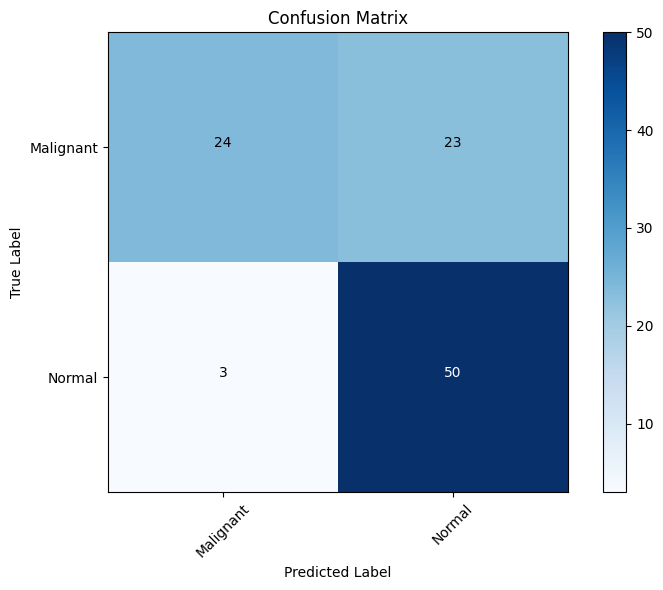

In [46]:
# Define classes
classes = ['Malignant', 'Normal']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

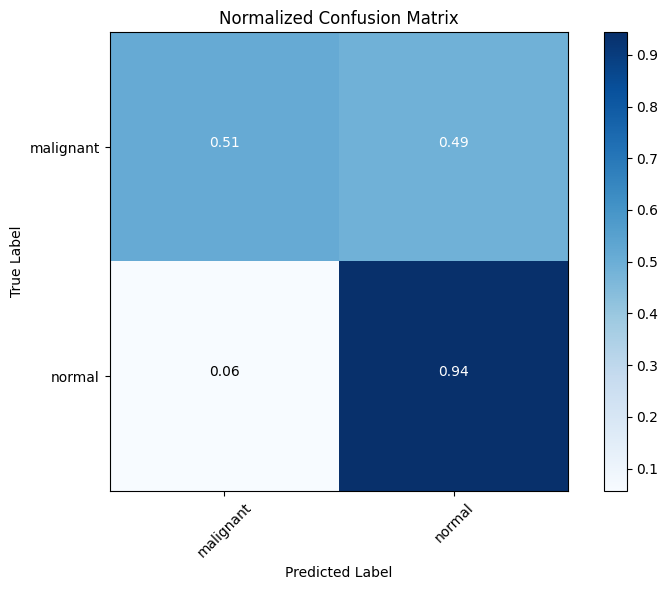

In [47]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate confusion matrix
cm = confusion_matrix(all_y_true, all_y_pred)

# Normalize confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Normalized Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(test_generator.class_indices))
plt.xticks(tick_marks, test_generator.class_indices, rotation=45)
plt.yticks(tick_marks, test_generator.class_indices)

# Add text annotations
fmt = '.2f'
thresh = cm_normalized.max() / 2.
for i in range(cm_normalized.shape[0]):
    for j in range(cm_normalized.shape[1]):
        plt.text(j, i, format(cm_normalized[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm_normalized[i, j] > thresh else "black")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


In [48]:
# Get the true labels for the entire test dataset
all_true_labels = np.concatenate([test_generator[i][1] for i in range(len(test_generator))])

# Predict labels for the entire test dataset
all_pred_labels = best_model.model.predict(test_generator).flatten()
all_pred_labels = (all_pred_labels > 0.5).astype(int)

# Generate the classification report
classification_rep = classification_report(all_true_labels, all_pred_labels)

# Print the classification report
print("Classification Report based on the entire test set:\n", classification_rep)


4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 626ms/step
Classification Report based on the entire test set:
               precision    recall  f1-score   support

         0.0       0.89      0.50      0.64        50
         1.0       0.65      0.94      0.77        50

    accuracy                           0.72       100
   macro avg       0.77      0.72      0.71       100
weighted avg       0.77      0.72      0.71       100



In [49]:
from sklearn.metrics import accuracy_score

# Calculate test accuracy based on the entire test set
test_accuracy = accuracy_score(all_true_labels, all_pred_labels)

# Print the test accuracy
print("Test Accuracy based on the entire test set:", test_accuracy)


Test Accuracy based on the entire test set: 0.72


In [68]:
import tensorflow as tf

# Define the model architecture
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    # Compile the model
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Create an instance of the model
model = create_model()

model.summary()

# Fit the model
history = model.fit(train_generator, epochs=15, batch_size=128)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Accuracy:", test_accuracy)


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_92"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_276 (Conv2D)             │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_276               │ (None, 63, 63, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_277 (Conv2D)             │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_277               │ (None, 30, 30, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_278 (Conv2D)             │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_278               │ (None, 14, 14, 128)    │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_92 (Flatten)            │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_184 (Dense)               │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_185 (Dense)               │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 197ms/step - accuracy: 0.5711 - loss: 0.7616
Epoch 2/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 208ms/step - accuracy: 0.7354 - loss: 0.4969
Epoch 3/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 223ms/step - accuracy: 0.7903 - loss: 0.4838
Epoch 4/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 808ms/step - accuracy: 0.7489 - loss: 0.5029
Epoch 5/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 425ms/step - accuracy: 0.8058 - loss: 0.4500
Epoch 6/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 455ms/step - accuracy: 0.8085 - loss: 0.4004
Epoch 7/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 395ms/step - accuracy: 0.8477 - loss: 0.3064
Epoch 8/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.8705 - loss: 0.2739
Epoch 9/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 209ms/step - accuracy: 0.8950 - loss: 0.2281
Epoch 10/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 197ms/step - accuracy: 0.9240 - loss: 0.1824
Epoch 11/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 219ms/step - accuracy: 0.9531 - loss: 0.1455
Epoch 12/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 212ms/step 

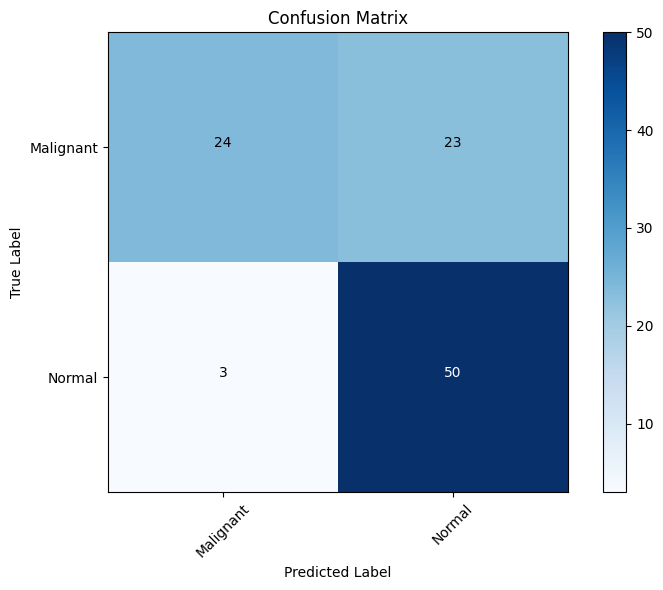

In [60]:
# Define classes
classes = ['Malignant', 'Normal']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

In [64]:
from sklearn.metrics import classification_report, f1_score

# Predict labels for the test data
y_pred = model.predict(test_generator)
y_pred = (y_pred > 0.5).astype('int32')

# Get true labels from the test generator
y_true = test_generator.classes

# Calculate F1 score
f1 = f1_score(y_true, y_pred)

# Generate classification report
report = classification_report(y_true, y_pred)

print("F1 Score:", f1)
print("Classification Report:")
print(report)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step
F1 Score: 0.4742268041237113
Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.52      0.50        50
           1       0.49      0.46      0.47        50

    accuracy                           0.49       100
   macro avg       0.49      0.49      0.49       100
weighted avg       0.49      0.49      0.49       100



In [56]:
from sklearn.metrics import classification_report

# Confusion matrix values
TP = 50
FP = 23
FN = 3
TN = 24

# Calculate precision, recall, and F1 score for each class
precision_class_0 = TN / (TN + FN)
recall_class_0 = TN / (TN + FP)
f1_score_class_0 = 2 * (precision_class_0 * recall_class_0) / (precision_class_0 + recall_class_0)

precision_class_1 = TP / (TP + FP)
recall_class_1 = TP / (TP + FN)
f1_score_class_1 = 2 * (precision_class_1 * recall_class_1) / (precision_class_1 + recall_class_1)

# Create a dictionary with metrics
classification_report_dict = {
    'precision': [precision_class_0, precision_class_1],
    'recall': [recall_class_0, recall_class_1],
    'f1-score': [f1_score_class_0, f1_score_class_1],
    'support': [TN + FP, TP + FN]
}

print(classification_report_dict)
# Generate classification report
print (classification_report(y_true, y_pred, target_names=classes))

{'precision': [0.8888888888888888, 0.684931506849315], 'recall': [0.5106382978723404, 0.9433962264150944], 'f1-score': [0.6486486486486487, 0.7936507936507937], 'support': [47, 53]}
              precision    recall  f1-score   support

   Malignant       0.53      0.50      0.52        50
      Normal       0.53      0.56      0.54        50

    accuracy                           0.53       100
   macro avg       0.53      0.53      0.53       100
weighted avg       0.53      0.53      0.53       100

